# <span style="color:blue">LDA model (2019_Oct) - 10 topics</span>

In [1]:
yyyy_MMM = '2019_Oct'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
from numpy import savetxt
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False
# if sample > 0, then we take a sample of the entire dataset (for debugging purpose)
sample = 0
# parameters to build the lda model
num_topics = 10

if test:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model'
    # chunksize to build LDA model
    chunksize = 250
else:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model'
    # chunksize to build LDA model
    chunksize = 5000

# path + name of the file that contains the documents preprocessed
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
# path + name of the file that contains the model gotten at the end
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Oct\2019_Oct_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model\2019_Oct\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc, index_col='id_doc')
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
637644     ['love', 'good', 'free', 'deal', 'well', 'free...
99299      ['trail', 'wannabee', 'cycling', 'club', 'stel...
370013     ['october', 'favorite', 'fall', 'flavor', 'min...
1470532    ['sire', 'style', 'fashion', 'shoe', 'moda', '...
471521     ['short', 'story', 'story', 'jeux', 'lles', 's...
1381828                                            ['phone']
988536     ['fast', 'hand', 'hand', 'big', 'large', 'cond...
1604186    ['cela', 'ressemble', 'caron', 'mais', 'sont',...
388705        ['summer', 'day', 'fashion', 'bikini', 'moda']
53708      ['freak', 'adorable', 'alpaca', 'moment', 'cut...
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
425647                    ['place', 'smile', 'philadelphia']
636797     ['kiss', 'hard', 'summertime', 'sadness', 'bab...
594280     ['lilo', 'stitch', 'beach', 'life', 'puppy', '...
100455     ['stage', 'brasil', 'ride', 'cini', 'sweet', '...
1327654    ['headpiece', 'design', 'concept', 'store', 'k...
1443553    ['night', 'woman', 'fashion', 'style', 'hair',...
1355748    ['soft', 'kiss', 'butter', 'pecan', 'balay', '...
1371162    ['lieben', 'pandora', 'wieder', 'ganzearbeitge...
991267     ['backstreet', 'boy', 'tour', 'exhibition', 'h...
410555     ['create', 'sign', 'trick', 'treater', 'knock'...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the number of words appearing in each document  

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(147910,)


<AxesSubplot:>

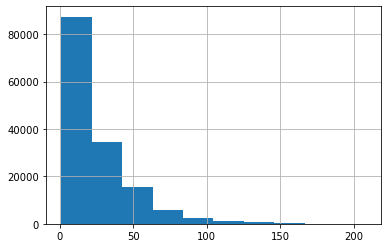

In [7]:
print(documents.shape)

documents.str.split().\
    map(lambda x: len(x)).\
    hist()

### Remove words that appear only once

In [8]:
####################### PENDING

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text

In [9]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bigrams & trigrams  

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [10]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Categorizing and tagging words

In [11]:
# function to remove accented characters
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dictionary with the entire dataset

In [12]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus_total = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save document-term matrix

In [13]:
# save document-term matrix
savetxt(file_model + '_document_term_matrix.csv', corpus_total, delimiter=',', fmt='% s')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Build LDA model

In [14]:
perplexity_score = []
coherence_score = []
indixes = []

index = 0
chunk_size = 250
documents_sample = documents[index:chunk_size-1]

time_start = time.time()

data_words = list(sent_to_words(documents_sample))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# # Create Dictionary
# id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=50
                                       ,per_word_topics=True)

indixes.append(index)

# Evaluate LDA Model
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
perplexity_score.append(perplexity)

# Evaluate LDA Model
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence = coherence_lda_model.get_coherence()
coherence_score.append(coherence)

# Save LDA Model
temp_file = datapath(file_model)
lda_model.save(temp_file)
temp_file = datapath(file_model + '_' + str(index).zfill(5))
lda_model.save(temp_file)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:47.51


### Incremental learning

In [15]:
documents_len = len(documents)

while index+(index+1)*chunk_size < documents_len:
    
    time_start = time.time()
    
    print(index, ' ----- ', (index+1)*chunk_size, ' ----- ', ((index+1)*chunk_size)+chunk_size-1)
    documents_sample = documents[(index+1)*chunk_size:((index+1)*chunk_size)+chunk_size-1]
    
    data_words = list(sent_to_words(documents_sample))
    # Compute bigrams & trigrams
    bi_tri_grams(data_words, 250)
    # Categorizing and tagging words
    data_words = list(map(tag_words, data_words))
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Load LDA Model
    temp_file = datapath(file_model)
    lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)
    # Update LDA Model
    lda_model.update(corpus)
    
    index = index + 1
    indixes.append(index)
    
    # Evaluate LDA Model
    # Compute Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_score.append(perplexity)

    # Evaluate LDA Model
    # Compute Coherence Score
    coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    
    # Save LDA Model
    temp_file = datapath(file_model)
    lda_model.save(temp_file)
    temp_file = datapath(file_model + '_' + str(index).zfill(5))
    lda_model.save(temp_file)
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

0  -----  250  -----  499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:49.41
1  -----  500  -----  749
time elapsed - 00:00:46.84
2  -----  750  -----  999
time elapsed - 00:00:45.16
3  -----  1000  -----  1249
time elapsed - 00:00:44.33
4  -----  1250  -----  1499
time elapsed - 00:00:44.81
5  -----  1500  -----  1749
time elapsed - 00:00:45.35
6  -----  1750  -----  1999
time elapsed - 00:00:45.78
7  -----  2000  -----  2249
time elapsed - 00:00:46.14
8  -----  2250  -----  2499
time elapsed - 00:00:52.83
9  -----  2500  -----  2749
time elapsed - 00:00:45.91
10  -----  2750  -----  2999
time elapsed - 00:00:45.98
11  -----  3000  -----  3249
time elapsed - 00:00:45.24
12  -----  3250  -----  3499
time elapsed - 00:00:45.33
13  -----  3500  -----  3749
time elapsed - 00:00:45.02
14  -----  3750  -----  3999
time elapsed - 00:00:45.17
15  -----  4000  -----  4249
time elapsed - 00:00:44.13
16  -----  4250  -----  4499
time elapsed - 00:00:44.20
17  -----  4500  -----  4749
time elapsed - 00:00:44.52
18  -----  4750  -----  4999
time 

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:47.85
26  -----  6750  -----  6999
time elapsed - 00:00:45.82
27  -----  7000  -----  7249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.33
28  -----  7250  -----  7499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.10
29  -----  7500  -----  7749
time elapsed - 00:00:44.68
30  -----  7750  -----  7999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.77
31  -----  8000  -----  8249
time elapsed - 00:00:45.64
32  -----  8250  -----  8499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:46.61
33  -----  8500  -----  8749
time elapsed - 00:00:45.37
34  -----  8750  -----  8999
time elapsed - 00:00:45.54
35  -----  9000  -----  9249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.31
36  -----  9250  -----  9499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.31
37  -----  9500  -----  9749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.22
38  -----  9750  -----  9999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.12
39  -----  10000  -----  10249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.64
40  -----  10250  -----  10499
time elapsed - 00:00:47.00
41  -----  10500  -----  10749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.58
42  -----  10750  -----  10999
time elapsed - 00:00:45.37
43  -----  11000  -----  11249
time elapsed - 00:00:44.50
44  -----  11250  -----  11499
time elapsed - 00:00:43.98
45  -----  11500  -----  11749
time elapsed - 00:00:45.30
46  -----  11750  -----  11999
time elapsed - 00:00:47.88
47  -----  12000  -----  12249
time elapsed - 00:00:47.65
48  -----  12250  -----  12499
time elapsed - 00:00:44.45
49  -----  12500  -----  12749
time elapsed - 00:00:44.96
50  -----  12750  -----  12999
time elapsed - 00:00:45.40
51  -----  13000  -----  13249
time elapsed - 00:00:44.58
52  -----  13250  -----  13499
time elapsed - 00:00:44.39
53  -----  13500  -----  13749
time elapsed - 00:00:43.62
54  -----  13750  -----  13999
time elapsed - 00:00:43.96
55  -----  14000  -----  14249
time elapsed - 00:00:43.77
56  -----  14250  -----  14499
time elapsed - 00:00:44.88
57  -----  14500  -----  14749
time elapsed - 00:00:45.39
58  -----  14750  -----  14999
time elapsed -

time elapsed - 00:00:44.29
182  -----  45750  -----  45999
time elapsed - 00:00:44.89
183  -----  46000  -----  46249
time elapsed - 00:00:44.32
184  -----  46250  -----  46499
time elapsed - 00:00:47.00
185  -----  46500  -----  46749
time elapsed - 00:00:45.63
186  -----  46750  -----  46999
time elapsed - 00:00:45.41
187  -----  47000  -----  47249
time elapsed - 00:00:45.20
188  -----  47250  -----  47499
time elapsed - 00:00:45.06
189  -----  47500  -----  47749
time elapsed - 00:00:44.43
190  -----  47750  -----  47999
time elapsed - 00:00:45.14
191  -----  48000  -----  48249
time elapsed - 00:00:45.31
192  -----  48250  -----  48499
time elapsed - 00:00:47.63
193  -----  48500  -----  48749
time elapsed - 00:00:46.56
194  -----  48750  -----  48999
time elapsed - 00:00:46.18
195  -----  49000  -----  49249
time elapsed - 00:00:46.22
196  -----  49250  -----  49499
time elapsed - 00:00:45.95
197  -----  49500  -----  49749
time elapsed - 00:00:47.18
198  -----  49750  -----  499

time elapsed - 00:00:51.65
321  -----  80500  -----  80749
time elapsed - 00:00:45.92
322  -----  80750  -----  80999
time elapsed - 00:00:50.93
323  -----  81000  -----  81249
time elapsed - 00:00:45.16
324  -----  81250  -----  81499
time elapsed - 00:00:43.46
325  -----  81500  -----  81749
time elapsed - 00:00:42.34
326  -----  81750  -----  81999
time elapsed - 00:00:45.24
327  -----  82000  -----  82249
time elapsed - 00:00:43.83
328  -----  82250  -----  82499
time elapsed - 00:00:43.35
329  -----  82500  -----  82749
time elapsed - 00:00:48.51
330  -----  82750  -----  82999
time elapsed - 00:00:46.78
331  -----  83000  -----  83249
time elapsed - 00:00:43.40
332  -----  83250  -----  83499
time elapsed - 00:00:43.98
333  -----  83500  -----  83749
time elapsed - 00:00:49.07
334  -----  83750  -----  83999
time elapsed - 00:00:45.15
335  -----  84000  -----  84249
time elapsed - 00:00:45.01
336  -----  84250  -----  84499
time elapsed - 00:00:44.53
337  -----  84500  -----  847

time elapsed - 00:00:47.04
458  -----  114750  -----  114999
time elapsed - 00:00:47.10
459  -----  115000  -----  115249
time elapsed - 00:00:49.75
460  -----  115250  -----  115499
time elapsed - 00:00:47.21
461  -----  115500  -----  115749
time elapsed - 00:00:47.72
462  -----  115750  -----  115999
time elapsed - 00:00:47.99
463  -----  116000  -----  116249
time elapsed - 00:00:47.81
464  -----  116250  -----  116499
time elapsed - 00:00:46.28
465  -----  116500  -----  116749
time elapsed - 00:00:45.13
466  -----  116750  -----  116999
time elapsed - 00:00:48.28
467  -----  117000  -----  117249
time elapsed - 00:00:47.10
468  -----  117250  -----  117499
time elapsed - 00:00:46.45
469  -----  117500  -----  117749
time elapsed - 00:00:49.71
470  -----  117750  -----  117999
time elapsed - 00:00:47.90
471  -----  118000  -----  118249
time elapsed - 00:00:47.15
472  -----  118250  -----  118499
time elapsed - 00:00:47.95
473  -----  118500  -----  118749
time elapsed - 00:00:47.

### Topics in LDA model

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"time" + 0.031*"today" + 0.029*"work" + 0.022*"link" + '
  '0.020*"product" + 0.017*"year" + 0.017*"visit" + 0.017*"people" + '
  '0.015*"book" + 0.014*"feel"'),
 (1,
  '0.031*"hollywood" + 0.027*"wait" + 0.027*"game" + 0.027*"corsair" + '
  '0.023*"business" + 0.023*"empowers" + 0.020*"slide" + 0.016*"bos" + '
  '0.016*"leaf" + 0.012*"jones"'),
 (2,
  '0.084*"fashion" + 0.063*"style" + 0.039*"blogger" + 0.033*"hair" + '
  '0.026*"life" + 0.023*"thing" + 0.020*"love" + 0.020*"week" + 0.017*"fall" + '
  '0.017*"food"'),
 (3,
  '0.042*"fitness" + 0.019*"challenge" + 0.019*"ballet" + 0.015*"mind" + '
  '0.015*"dance" + 0.015*"glass" + 0.015*"issue" + 0.015*"break" + '
  '0.015*"matter" + 0.015*"director"'),
 (4,
  '0.090*"beauty" + 0.028*"halloween" + 0.026*"video" + 0.022*"day" + '
  '0.020*"makeup" + 0.020*"artist" + 0.020*"brand" + 0.018*"baby" + '
  '0.016*"lover" + 0.016*"help"'),
 (5,
  '0.047*"wine" + 0.018*"recipe" + 0.018*"cream" + 0.015*"farm" + 0.015*"feed" '
  '+

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot perplexity score progress along incremental learning iterations  

Lower the perplexity score represents a better model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


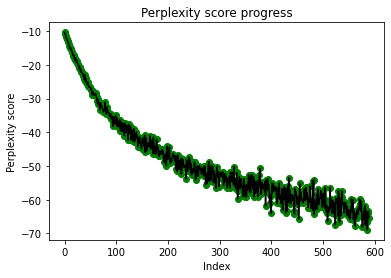

In [17]:
plt.title('Perplexity score progress')
plt.xlabel('Index')
plt.ylabel('Perplexity score')
plt.plot(indixes, perplexity_score, 'go', perplexity_score, 'k')
plt.show()

### Plot coherence score progress along incremental learning iterations  

Higher the coherence score represents a more human interpretable model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


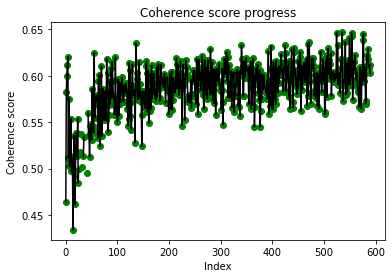

In [18]:
plt.title('Coherence score progress')
plt.xlabel('Index')
plt.ylabel('Coherence score')
plt.plot(indixes, coherence_score, 'go', coherence_score, 'k') 
plt.show()

### Visualize the topics-keywords

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.432652 -0.152630       1        1  25.917378
0     -0.000840  0.245800       2        1  17.437091
4      0.092282  0.314693       3        1  12.414589
5     -0.031909  0.072387       4        1   8.690772
6     -0.050910 -0.113872       5        1   6.948038
3     -0.091141 -0.063653       6        1   6.689162
1     -0.122388 -0.105992       7        1   6.467087
9     -0.073237 -0.083532       8        1   5.892611
7     -0.075584 -0.033271       9        1   4.788692
8     -0.078926 -0.079929      10        1   4.754579, topic_info=          Term       Freq      Total Category  logprob  loglift
11     fashion  85.000000  85.000000  Default  30.0000  30.0000
68      beauty  43.000000  43.000000  Default  29.0000  29.0000
51       style  64.000000  64.000000  Default  28.0000  28.0000
6      blogger  39.000000  39.000000  Default  27.0000  27.0000
340       time  28.000000  28.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
2591     focus   1.999707   2.001213  Topic10  -4.5391   3.0453
246    villain   1.999028   2.000535  Topic10  -4.5395   3.0453
4576      drag   1.999028   2.000535  Topic10  -4.5395   3.0453
4159     comme   3.596099   3.978750  Topic10  -3.9523   2.9449
20447  garcons   3.441057   3.970836  Topic10  -3.9963   2.9029

[369 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
505       8  0.999027        action
1370      8  1.000287        addict
601       3  1.025790        agency
426       9  0.996751  architecture
66        3  1.025832        artist
...     ...       ...           ...
2187      6  0.998888       workout
512       2  1.039479          year
979       6  0.997024     yesterday
1711      5  1.007277          york
1687      9  0.998739       youtube

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 6, 7, 4, 2, 10, 8, 9])

### Save document-topic matrix (most significant topic per document)  
 https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
 https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

doc_num, topic_num, prob = [], [], []

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
    
data = {'Document': doc_num
        ,'Topic': topic_num
        ,'Probability': prob}
df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document  Topic  Probability
0         425647      8     0.366805
1         636797      2     0.660319
2         594280      8     0.366772
3         100455      8     0.551457
4        1327654      2     0.796046
...          ...    ...          ...
147905   1053861      2     0.349973
147906    544735      0     0.435725
147907    398207      2     0.392339
147908    598862      0     0.401830
147909   1222446      0     0.619980

[147910 rows x 3 columns]


### Save document-topic matrix (all topic's probability per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [21]:
doc_num = []
prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9 = ([] for i in range(num_topics))

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    prob0.append(get_document_topics[0][1])
    prob1.append(get_document_topics[1][1])
    prob2.append(get_document_topics[2][1])
    prob3.append(get_document_topics[3][1])
    prob4.append(get_document_topics[4][1])
    prob5.append(get_document_topics[5][1])
    prob6.append(get_document_topics[6][1])
    prob7.append(get_document_topics[7][1])
    prob8.append(get_document_topics[8][1])
    prob9.append(get_document_topics[9][1])
    
data = {'Document': doc_num
        ,'Topic0': prob0
        ,'Topic1': prob1
        ,'Topic2': prob2
        ,'Topic3': prob3
        ,'Topic4': prob4
        ,'Topic5': prob5
        ,'Topic6': prob6
        ,'Topic7': prob7
        ,'Topic8': prob8
        ,'Topic9': prob9}

df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix_full.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0         425647  0.033329  0.033329  0.366566  0.033329  0.033329  0.033329   
1         636797  0.040691  0.003699  0.660321  0.040685  0.162126  0.003699   
2         594280  0.033336  0.033326  0.366612  0.033326  0.033326  0.033326   
3         100455  0.049845  0.049827  0.049827  0.049827  0.049827  0.049827   
4        1327654  0.049622  0.004680  0.796047  0.004680  0.121571  0.004680   
...          ...       ...       ...       ...       ...       ...       ...   
147905   1053861  0.183333  0.016665  0.349973  0.016665  0.183310  0.016665   
147906    544735  0.435711  0.214049  0.214038  0.019457  0.019457  0.019457   
147907    398207  0.009569  0.009569  0.392333  0.105228  0.009569  0.244105   
147908    598862  0.401830  0.073938  0.141075  0.006719  0.208358  0.006715   
147909   1222446  0.619980  0.019998  0.019998  0.019998  0.019998  0.019998   

          Topic6    Topic7    Topic8   

### Save topic-term matrix

In [22]:
# get topic-term-matrix
topic_term_matrix = lda_model.get_topics()
# save topic-term matrix
savetxt(file_model + '_topic_term_matrix.csv', topic_term_matrix, delimiter=',')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
